# Counts over threshold in different windows (v2)
This program computes the number of samples above or below a prefixed threshold.
For each channel we obtain:

    * Plot of counts vs threshold for several voltages of scintillators
    * Plot of counts vs scintillator voltage for several values of threshold, and linear fits
    * Slope of the fits versus threshold
v2: counts event by event and then we apply mean

###### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as patch
import matplotlib.cm as cm
import time
import os
os.chdir('..')
import csv
import scipy.stats as sct
import scipy.optimize as sco
from random import randrange
from collections import Counter
import microcodes_modules.functions as fc
from microcodes_modules.events import Event
from microcodes_modules.CAENReader import WDReader
from microcodes_modules.CAENReader import readChannels
from microcodes_modules.auto_plots import histo_stats
from collections import Counter

In [2]:
colors1 = cm.hot(np.linspace(0,1,8))
colors2 = cm.gnuplot(np.linspace(0,1,10))

In [3]:
### SETTINGS ######################################################################################

###### Settings to read data (options IN)
""" Legend:
        * in_dir -> name of input directory
        * ADC_ch -> number of ADC channels, equal to 2^Nbits
        * nsamp -> number of samples per event
        * deltaT -> real time separation between two samples
        * Vpp -> voltage peak to peak
        * ngroups -> number of groups to study data
        * Nevents -> number of events per group
"""
in_dis  =     ['wavesh_211105_1146_70h10',
               'wavesh_211029_1300_92h00',
               'wavesh_211102_0955_47h43',
               'wavesh_211104_1102_23h00',
               'wavesh_211108_1029_0h38']
voltages=    [770,780,800,820,900]           # !!! voltages applied to scintillators
nbits   =    14                              # !!! number of bits for ADC channels
nsamp   =    1030                            # !!! number of samples per event
deltaT  =    4                               # !!! real time separation between two samples
Vpp     =    2.0                             # !!! voltage peak to peak
ADC_ch  =    2**nbits                        # number of ADC_channels, equal to 2**nbits
Fs      =    1/deltaT * 1e9                  # sampling frequency (Hz)
R       =    50                              # input impedance
ngroups =    1                               # number of groups to study data
Nevents =    'ind'                           # number of events per group

cntr_of_fwin = nsamp/2 # Here is the trigger
# Delays induced by the travel of signals by the cable from antennas to digitizer:
cable_delays = np.array([576.5,574.8,403.0,403.0,286.5,284.7,209.0,207.2]) # ns
# Time of particles from antennas height to floor (where scintillator is)
particle_delay = 30 #ns
# Approximated time of delay of trigger
trigger_delay = 30 #ns
# Total expected pulse delay = cable_delays - particle_delay - trigger_delay
total_delay = cable_delays - particle_delay - trigger_delay
print('Total delay for each channel: ', total_delay, '\n')

win = 200 # width of window in ns. Must be multiple of 4

Total delay for each channel:  [516.5 514.8 343.  343.  226.5 224.7 149.  147.2] 



In [4]:
baseline = ADC_ch//2
rel_th = [0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99] # threshold in units of maximum of one event

In [5]:
Counts_sel   = {}
Counts_rnd = {}
Counts_diffs = {}
sCounts_sel   = {}
sCounts_rnd = {}
sCounts_diffs = {}

In [6]:
ini_for_th = 0
fin_for_th = 1000

In [7]:
for i,in_dir in enumerate(in_dis):
    
    Volt = voltages[i]
    print('\n ===> '+str(Volt))
    READ = readChannels('DATA/'+in_dir,Vpp=2.0)
    DATA = READ.data()
    nevents = READ.nevents()
    print('Number of events:', nevents)
    file_list = READ.files_list()
    print(file_list)
    
    Counts_sel[Volt] = {}
    Counts_rnd[Volt] = {}
    Counts_diffs[Volt] = {}
    sCounts_sel[Volt] = {}
    sCounts_rnd[Volt] = {}
    sCounts_diffs[Volt] = {}
    
    for wave in file_list:
        ich = int(wave[-5])
        
        Counts_sel[Volt][ich] = {}
        Counts_rnd[Volt][ich] = {}
        Counts_diffs[Volt][ich] = {}
        sCounts_sel[Volt][ich] = {}
        sCounts_rnd[Volt][ich] = {}
        sCounts_diffs[Volt][ich] = {}
        
        presel = 40 # ns
        ini = int(cntr_of_fwin) + int(total_delay[ich]/deltaT) - presel//deltaT #we assume a Hilbert pulse that begins when the signal arrives to antennas
        fin = ini + win//deltaT
        rndini = 0
        rndfin = rndini + win//deltaT
        print(' Ch ', ich)
        print('Index of start and end of window: ', ini,fin)
        print('Time of start and end of window:  ', ini*deltaT,fin*deltaT)
        
        counts_sel = {}
        counts_rnd = {}
        counts_diffs = {}
        for rth in rel_th:
            counts_sel[rth] = []
            counts_rnd[rth] = []
            counts_diffs[rth] = []
        
        for iev,event in DATA[ich].items():
            sel_values = event[1][ini:fin]
            rnd_values = event[1][rndini:rndfin]
        
            sel_counts = Counter(sel_values)
            rnd_counts = Counter(rnd_values)
            rango  = np.arange(0,ADC_ch)
            histo_sel  = np.array([0]*ADC_ch)
            histo_rnd  = np.array([0]*ADC_ch)
            for j in range(len(rango)):  # Making Histograms
                histo_sel[j] = sel_counts[j]
                histo_rnd[j] = rnd_counts[j]
        
            ntcounts_sel = sum(histo_sel)
            ntcounts_rnd = sum(histo_rnd)
        
            histo_sel = [item for item in histo_sel]
            histo_rnd = [item for item in histo_rnd]
            
            maxi = max([np.abs(item-baseline) for item in event[1][ini_for_th:fin_for_th]]) # the maximum is chosen from a window at the starting of the event
            thresholds = [int(fct*maxi) for fct in rel_th]
            for i,th in enumerate(thresholds):
                ith_over = baseline + th ;  ith_undr = baseline - th
                cnt_sel = (sum(histo_sel[:ith_undr]) + sum(histo_sel[ith_over:]))/ntcounts_sel
                cnt_rnd = (sum(histo_rnd[:ith_undr]) + sum(histo_rnd[ith_over:]))/ntcounts_rnd
                counts_sel[rel_th[i]].append(cnt_sel)
                counts_rnd[rel_th[i]].append(cnt_rnd)
                counts_diffs[rel_th[i]].append(cnt_sel-cnt_rnd)
        
        for rth in rel_th:
            Counts_sel[Volt][ich][rth]    = np.mean(counts_sel[rth])
            Counts_rnd[Volt][ich][rth]    = np.mean(counts_rnd[rth])
            Counts_diffs[Volt][ich][rth]  = np.mean(counts_diffs[rth])
            sCounts_sel[Volt][ich][rth]   = np.std(counts_sel[rth])
            sCounts_rnd[Volt][ich][rth]   = np.std(counts_rnd[rth])
            sCounts_diffs[Volt][ich][rth] = np.std(counts_diffs[rth])


 ===> 770
file            wave0.dat   size       4086.7 KB
file            wave1.dat   size       4086.7 KB
file            wave2.dat   size       4086.7 KB
file            wave3.dat   size       4086.7 KB
file            wave4.dat   size       4086.7 KB
file            wave5.dat   size       4086.7 KB
file            wave6.dat   size       4086.7 KB
file            wave7.dat   size       4086.7 KB
 Reading file wave0.dat...
  INFO. Reading with header
 Reading file wave1.dat...
  INFO. Reading with header
 Reading file wave2.dat...
  INFO. Reading with header
 Reading file wave3.dat...
  INFO. Reading with header
 Reading file wave4.dat...
  INFO. Reading with header
 Reading file wave5.dat...
  INFO. Reading with header
 Reading file wave6.dat...
  INFO. Reading with header
 Reading file wave7.dat...
  INFO. Reading with header
 Working directory: /home/daniel/Documentos/HYBRID/Antenas
Number of events: 1961
['wave0.dat', 'wave1.dat', 'wave2.dat', 'wave3.dat', 'wave4.dat', 'wave5.da

KeyboardInterrupt: 

In [8]:
outdata_sel = open('Counts_sel.csv','w')
writer_sel = csv.writer(outdata_sel)
outdata_rnd = open('Counts_rnd.csv','w')
writer_rnd = csv.writer(outdata_rnd)
outdata_diffs = open('Counts_diffs.csv','w')
writer_diffs = csv.writer(outdata_diffs)

outdata_ssel = open('Counts_ssel.csv','w')
writer_ssel = csv.writer(outdata_ssel)
outdata_srnd = open('Counts_srnd.csv','w')
writer_srnd = csv.writer(outdata_srnd)
outdata_sdiffs = open('Counts_sdiffs.csv','w')
writer_sdiffs = csv.writer(outdata_sdiffs)

for rth in rel_th:
    row_sel = [rth]
    row_rnd = [rth]
    row_diffs = [rth]
    row_ssel = [rth]
    row_srnd = [rth]
    row_sdiffs = [rth]
    for Volt in voltages:
        for ich in range(8):
            row_sel.append(Counts_sel[Volt][ich][rth])
            row_rnd.append(Counts_rnd[Volt][ich][rth])
            row_diffs.append(Counts_diffs[Volt][ich][rth])
            row_ssel.append(sCounts_sel[Volt][ich][rth])
            row_srnd.append(sCounts_rnd[Volt][ich][rth])
            row_sdiffs.append(sCounts_diffs[Volt][ich][rth])
    writer_sel.writerow(row_sel)
    writer_rnd.writerow(row_rnd)
    writer_diffs.writerow(row_diffs)
    writer_ssel.writerow(row_ssel)
    writer_srnd.writerow(row_srnd)
    writer_sdiffs.writerow(row_sdiffs)
    
outdata_sel.close()
outdata_rnd.close()
outdata_diffs.close()
outdata_ssel.close()
outdata_srnd.close()
outdata_sdiffs.close()

### Plots

#### Counts versus threshold

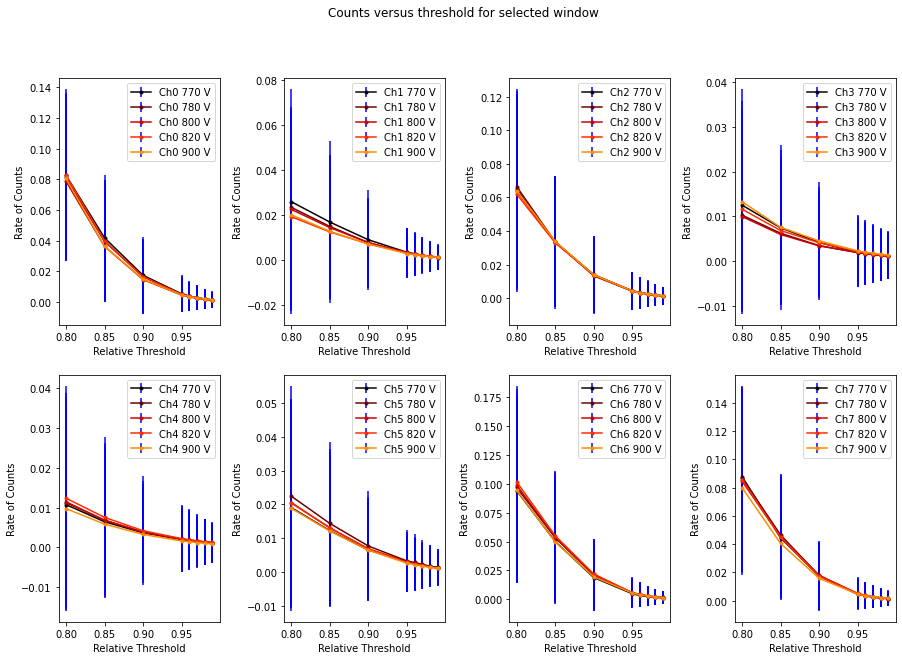

In [9]:
fig1 = plt.figure(1,figsize=(15,10))
fig1.suptitle('Counts versus threshold for selected window')
fig1.subplots_adjust(hspace=0.2,wspace=0.4)


for ich in range(8):
    ax1 = fig1.add_subplot(2,4,ich+1)
    for Volt in voltages:
        J = voltages.index(Volt)
        x = [] ;  y = []
        y_err = []
        for th,counts in Counts_sel[Volt][ich].items():
            x.append(th) ;  y.append(counts)
        for th,error in sCounts_sel[Volt][ich].items():
            y_err.append(error)
        
        ax1.errorbar(x,y,yerr=y_err,linestyle='-',marker='.',color=colors1[J],ecolor='blue',label='Ch'+str(ich)+' '+str(Volt)+' V')
        ax1.set_xlabel('Relative Threshold')
        ax1.set_ylabel('Rate of Counts')
        #ax1.set_xlim(thresholds[ich][0],thresholds[ich][-1])
        #ax1.set_ylim(0,1)
        #ax1.grid()
        ax1.legend()       
#plt.show()

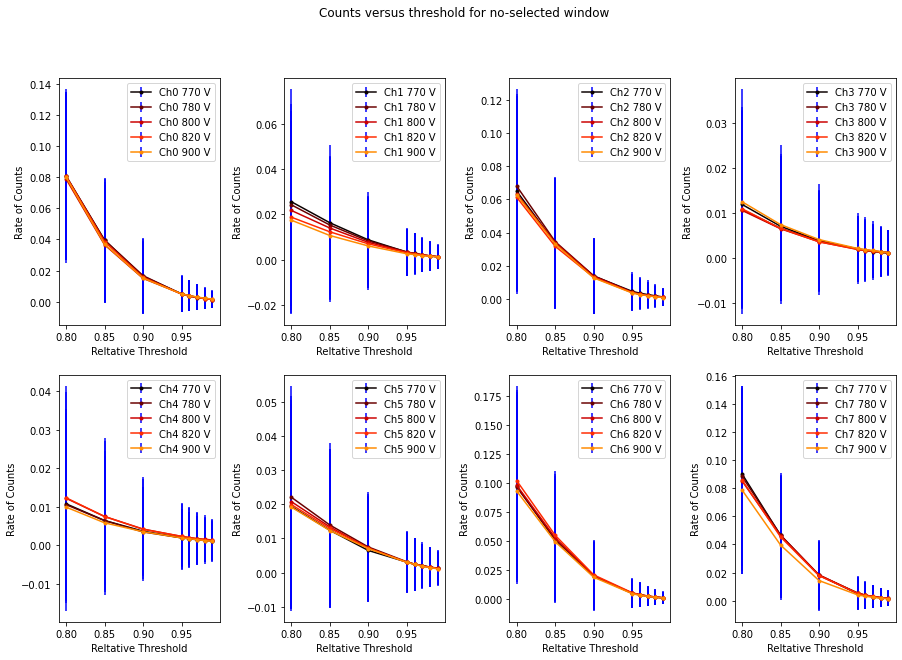

In [10]:
fig2 = plt.figure(2,figsize=(15,10))
fig2.suptitle('Counts versus threshold for no-selected window')
fig2.subplots_adjust(hspace=0.2,wspace=0.4)

for ich in range(8):
    ax2 = fig2.add_subplot(2,4,ich+1)
    for Volt in voltages:
        J = voltages.index(Volt)
        x = [] ;  y = []
        y_err = []
        for th,counts in Counts_rnd[Volt][ich].items():
            x.append(th) ;  y.append(counts)
        for th,error in sCounts_rnd[Volt][ich].items():
            y_err.append(error)
        
        ax2.errorbar(x,y,yerr=y_err,linestyle='-',marker='.',color=colors1[J],ecolor='blue',label='Ch'+str(ich)+' '+str(Volt)+' V')
        ax2.set_xlabel('Reltative Threshold')
        ax2.set_ylabel('Rate of Counts')
        #ax2.set_xlim(thresholds[ich][0],thresholds[ich][-1])
        #ax2.set_ylim(0,1)
        #ax2.grid()
        ax2.legend()       
#plt.show()

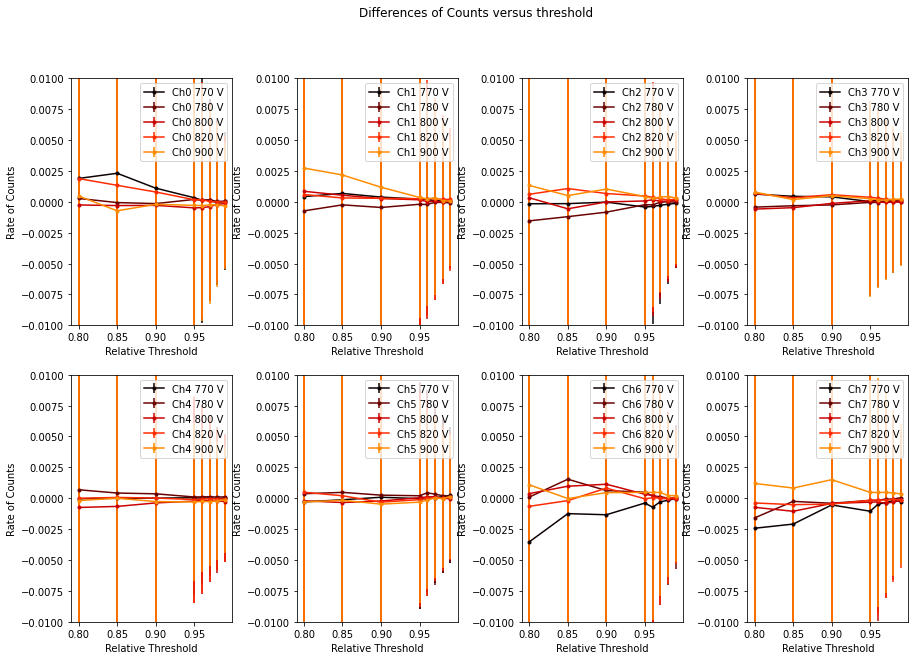

In [11]:
fig3 = plt.figure(3,figsize=(15,10))
fig3.suptitle('Differences of Counts versus threshold')
fig3.subplots_adjust(hspace=0.2,wspace=0.4)


for ich in range(8):
    ax3 = fig3.add_subplot(2,4,ich+1)
    for Volt in voltages:
        J = voltages.index(Volt)
        x = [] ;  y = []
        y_err = []
        for th,counts in Counts_diffs[Volt][ich].items():
            x.append(th) ;  y.append(counts)
        for th,error in sCounts_sel[Volt][ich].items():
            y_err.append(error)
        
        ax3.errorbar(x,y,yerr=y_err,linestyle='-',marker='.',color=colors1[J],ecolor=colors1[J],label='Ch'+str(ich)+' '+str(Volt)+' V')
        ax3.set_xlabel('Relative Threshold')
        ax3.set_ylabel('Rate of Counts')
        #ax3.set_xlim(thresholds[0],thresholds[-1])
        ax3.set_ylim(-0.01,0.01)
        #ax3.grid()
        ax3.legend()       
#plt.show()

#### Counts versus scintillator voltage

In [12]:
def recta(x,a,b):
    return a*x + b

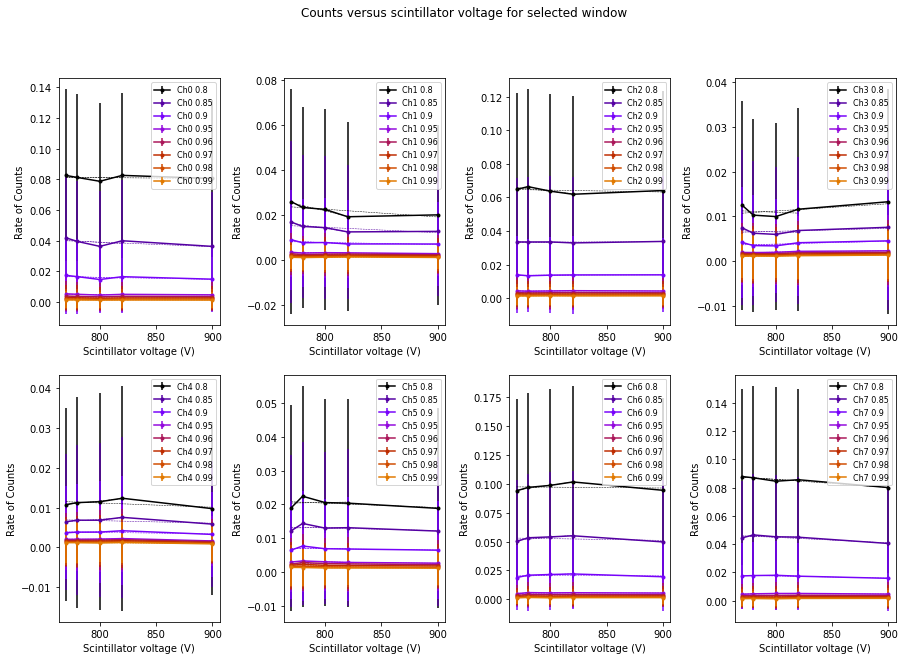

In [13]:
fig1 = plt.figure(1,figsize=(15,10))
fig1.suptitle('Counts versus scintillator voltage for selected window')
fig1.subplots_adjust(hspace=0.2,wspace=0.4)

fit_params_sel = {}
fit_params2_sel = {}
for ich in range(8):
    fit_params_sel[ich] = {}
    fit_params2_sel[ich] = {}
    ax1 = fig1.add_subplot(2,4,ich+1)
    #print(' ===> Ch' + str(ich))
    for j,th in enumerate(rel_th):
        #print('      Threshold ' + str(th))
        fit_params_sel[ich][th] = {}   # fit params 1
        fit_params2_sel[ich][th] = {}  # fit params 2
        x = [] ;  y = []
        y_err = []
        for Volt in voltages:
            x.append(Volt)
            y.append(Counts_sel[Volt][ich][th])
            y_err.append(sCounts_sel[Volt][ich][th])
        
        # (1) Fit to all points:
        if not all([item == y[0] for item in y]):
            if all(y_err):  # !!! change
                popt, pcov = sco.curve_fit(recta,x,y,sigma=y_err)
                a,b = popt
                fit_params_sel[ich][th]['a'] = a
                fit_params_sel[ich][th]['b'] = b
                fit_result = recta(np.array(voltages),a,b)
                chisq = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y,fit_result)])
                fit_params_sel[ich][th]['chi2'] = chisq
                ax1.plot(voltages,fit_result,color=colors2[j],linewidth=0.5,linestyle='--')
        
        # (2) Fit to points excluding the last:
        if not all([item == y[0] for item in y[:-1]]):
            if all(y_err[:-1]):
                popt2, pcov2 = sco.curve_fit(recta,x[:-1],y[:-1],sigma=y_err[:-1])
                a2,b2 = popt2
                fit_params2_sel[ich][th]['a'] = a2
                fit_params2_sel[ich][th]['b'] = b2
                fit_result2 = recta(np.array(voltages[:-1]),a2,b2)
                chisq2 = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y[:-1],fit_result2)])
                fit_params2_sel[ich][th]['chi2'] = chisq2
                ax1.plot(voltages[:-1],fit_result2,color=colors2[j],linewidth=0.5,linestyle='--')
        
        chi_str = (' %5.1e %5.1e' %(chisq,chisq2))
        ax1.errorbar(x,y,yerr=y_err,linestyle='-',marker='.',color=colors2[j],label='Ch'+str(ich)+' '+str(th)) #+' '+chi_str)
        ax1.set_xlabel('Scintillator voltage (V)')
        ax1.set_ylabel('Rate of Counts')
        #ax1.set_xlim(thresholds[0],thresholds[-1])
        #ax1.set_ylim(0,1)
        #ax1.grid()
        ax1.legend(prop={'size':8})
        #time.sleep(1)
#plt.show()

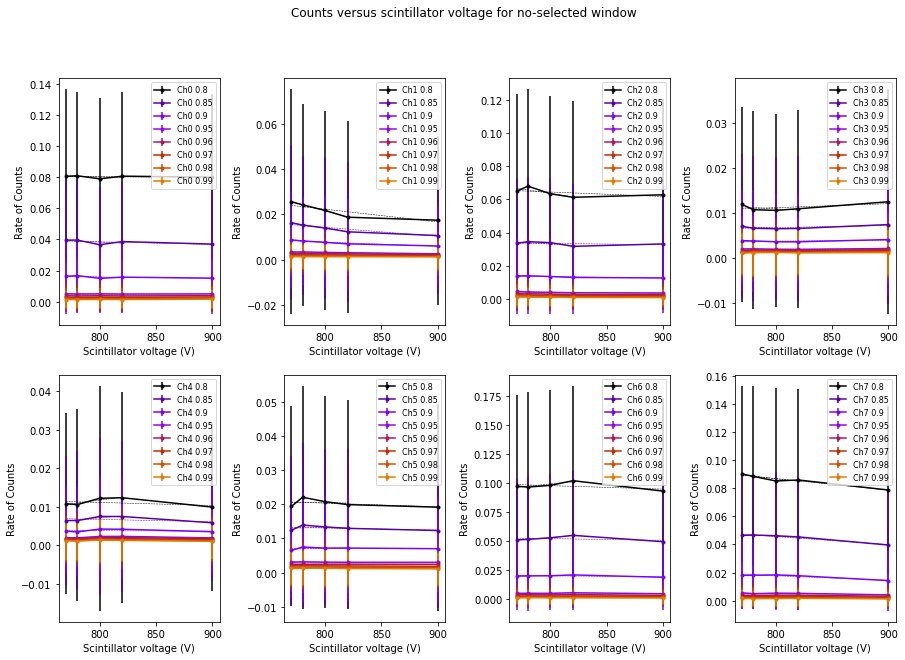

In [14]:
fig2 = plt.figure(2,figsize=(15,10))
fig2.suptitle('Counts versus scintillator voltage for no-selected window')
fig2.subplots_adjust(hspace=0.2,wspace=0.4)

fit_params_rnd = {}
fit_params2_rnd = {}
for ich in range(8):
    fit_params_rnd[ich] = {}
    fit_params2_rnd[ich] = {}
    ax2 = fig2.add_subplot(2,4,ich+1)
    #print(' ===> Ch' + str(ich))
    for j,th in enumerate(rel_th):
        #print('      Threshold ' + str(th))
        fit_params_rnd[ich][th] = {}   # fit params 1
        fit_params2_rnd[ich][th] = {}  # fit params 2
        x = [] ;  y = []
        y_err = []
        for Volt in voltages:
            x.append(Volt)
            y.append(Counts_rnd[Volt][ich][th])
            y_err.append(sCounts_rnd[Volt][ich][th])
        
        # (1) Fit to all points:
        if not all([item == y[0] for item in y]):
            if all(y_err):
                popt, pcov = sco.curve_fit(recta,x,y,sigma=y_err)
                a,b = popt
                fit_params_rnd[ich][th]['a'] = a
                fit_params_rnd[ich][th]['b'] = b
                fit_result = recta(np.array(voltages),a,b)
                chisq = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y,fit_result)])
                fit_params_rnd[ich][th]['chi2'] = chisq
                ax2.plot(voltages,fit_result,color=colors2[j],linewidth=0.5,linestyle='--')
        
        # (2) Fit to points excluding the last:
        if not all([item == y[0] for item in y[:-1]]):
            if all(y_err[:-1]):
                popt2, pcov2 = sco.curve_fit(recta,x[:-1],y[:-1],sigma=y_err[:-1])
                a2,b2 = popt2
                fit_params2_rnd[ich][th]['a'] = a2
                fit_params2_rnd[ich][th]['b'] = b2
                fit_result2 = recta(np.array(voltages[:-1]),a2,b2)
                chisq2 = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y[:-1],fit_result2)])
                fit_params2_rnd[ich][th]['chi2'] = chisq2
                ax2.plot(voltages[:-1],fit_result2,color=colors2[j],linewidth=0.5,linestyle='--')
        
        chi_str = (' %5.1e %5.1e' %(chisq,chisq2))
        ax2.errorbar(x,y,yerr=y_err,linestyle='-',marker='.',color=colors2[j],label='Ch'+str(ich)+' '+str(th)) #+' '+chi_str)
        ax2.set_xlabel('Scintillator voltage (V)')
        ax2.set_ylabel('Rate of Counts')
        #ax2.set_xlim(thresholds[0],thresholds[-1])
        #ax2.set_ylim(0,1)
        #ax2.grid()
        ax2.legend(prop={'size':8})
#plt.show()

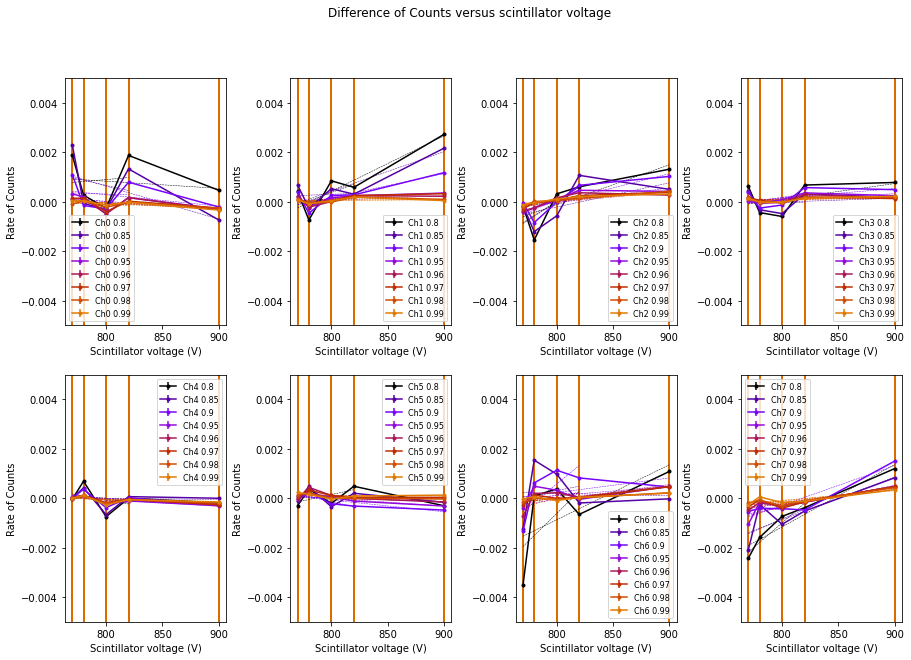

In [15]:
fig3 = plt.figure(2,figsize=(15,10))
fig3.suptitle('Difference of Counts versus scintillator voltage')
fig3.subplots_adjust(hspace=0.2,wspace=0.4)

fit_params_diffs = {}
fit_params2_diffs = {}
for ich in range(8):
    fit_params_diffs[ich] = {}
    fit_params2_diffs[ich] = {}
    ax3 = fig3.add_subplot(2,4,ich+1)
    #print(' ===> Ch' + str(ich))
    for j,th in enumerate(rel_th):
        #print('      Threshold ' + str(th))
        fit_params_diffs[ich][th] = {}   # fit params 1
        fit_params2_diffs[ich][th] = {}  # fit params 2
        x = [] ;  y = []
        y_err = []
        for Volt in voltages:
            x.append(Volt)
            y.append(Counts_diffs[Volt][ich][th])
            y_err.append(sCounts_diffs[Volt][ich][th])
        
        # (1) Fit to all points:
        if not all([item == y[0] for item in y]):
            if all(y_err):
                popt, pcov = sco.curve_fit(recta,x,y,sigma=y_err)
                a,b = popt
                fit_params_diffs[ich][th]['a'] = a
                fit_params_diffs[ich][th]['b'] = b
                fit_result = recta(np.array(voltages),a,b)
                chisq = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y,fit_result)])
                fit_params_diffs[ich][th]['chi2'] = chisq
                ax3.plot(voltages,fit_result,color=colors2[j],linewidth=0.5,linestyle='--')
        
        # (2) Fit to points excluding the last:
        if not all([item == y[0] for item in y[:-1]]):
            if all(y_err[:-1]):
                popt2, pcov2 = sco.curve_fit(recta,x[:-1],y[:-1],sigma=y_err[:-1])
                a2,b2 = popt2
                fit_params2_diffs[ich][th]['a'] = a2
                fit_params2_diffs[ich][th]['b'] = b2
                fit_result2 = recta(np.array(voltages[:-1]),a2,b2)
                chisq2 = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y[:-1],fit_result2)])
                fit_params2_diffs[ich][th]['chi2'] = chisq2
                ax3.plot(voltages[:-1],fit_result2,color=colors2[j],linewidth=0.5,linestyle='--')
        
        chi_str = (' %5.1e %5.1e' %(chisq,chisq2))
        ax3.errorbar(x,y,yerr=y_err,linestyle='-',marker='.',color=colors2[j],label='Ch'+str(ich)+' '+str(th)) #+' '+chi_str)
        ax3.set_xlabel('Scintillator voltage (V)')
        ax3.set_ylabel('Rate of Counts')
        #ax3.set_xlim(thresholds[0],thresholds[-1])
        ax3.set_ylim(-0.005,0.005)
        #ax3.grid()
        ax3.legend(prop={'size':8})
#plt.show()